In [24]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [25]:
# Create 'models/rf' directory to store model and related files
os.makedirs('../models/rf', exist_ok=True)

In [26]:
# Load dataset from CSV file
df = pd.read_csv('../Dataset/new_figma_dataset8.csv')
if 'parent_tag_html' in df.columns:
    df = df.drop(columns=['parent_tag_html'])
if 'y' in df.columns:
    df = df.drop(columns=['y'])

In [27]:
# Display first few rows to inspect data structure
print("Dataset Preview:")
print(df.head())

Dataset Preview:
    tag     type     width    height  sibling_count prev_sibling_html_tag  \
0   DIV    GROUP  1.000000  1.000000              0                   NaN   
1   DIV    GROUP  0.514831  0.852539              1                   NaN   
2  ICON  ELLIPSE  0.022599  0.036655              1                   NaN   
3  FORM    FRAME  0.469633  0.926690              1                  ICON   
4   DIV    GROUP  0.362288  0.093943              7                   NaN   

   has_background_color  border_radius  aspect_ratio child_1_html_tag  \
0                     0            0.0      1.382812              DIV   
1                     0            0.0      0.835052             ICON   
2                     1            0.0      1.000000              NaN   
3                     0            0.0      0.822002              DIV   
4                     0            0.0      6.750000               H1   

  child_2_html_tag  child_1_percentage_of_parent  \
0              SVG           

In [28]:
# Define features (X) and target (y)
y = df['tag']  
X = df.drop(columns=['tag']) 

In [29]:
# Define column categories based on the dataset attributes
categorical_cols = ['type','prev_sibling_html_tag','child_1_html_tag','child_2_html_tag']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [ ]:
# Handle missing values and data types
# Convert numerical columns to numeric, coercing errors to NaN
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing numerical values with median (robust to outliers)
num_imputer = SimpleImputer(strategy='median')
imputed_data = num_imputer.fit_transform(df[numerical_cols])
print("Shape of imputed data:", imputed_data.shape)
df[numerical_cols] = imputed_data
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Convert categorical columns to strings and impute missing values with 'missing'
df[categorical_cols] = df[categorical_cols].astype(str)
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Encode target variable using LabelEncoder
tag_encoder = LabelEncoder()
df['tag'] = tag_encoder.fit_transform(df['tag'])

Numerical columns: ['width', 'height', 'sibling_count', 'has_background_color', 'border_radius', 'aspect_ratio', 'child_1_percentage_of_parent', 'child_2_percentage_of_parent', 'distinct_background', 'center_of_weight_diff', 'is_verb', 'has_placeholder', 'nearest_text_node_dist']
Shape of df[numerical_cols]: (22987, 13)
Shape of imputed data: (22987, 13)


In [31]:
# Update X and y after preprocessing
X = df.drop(columns=['tag'])
y = df['tag']

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), categorical_cols)
    ])

In [33]:
# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 18389 samples
Test set size: 4598 samples


In [34]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples at a leaf
}

In [35]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
print("Starting hyperparameter tuning...")
grid_search.fit(preprocessor.fit_transform(X_train), y_train)

# Get best model and parameters
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Save preprocessor, model, and encoders
joblib.dump(preprocessor, '../models/rf/preprocessor.pkl')
joblib.dump(best_model, '../models/rf/html_tag_model.pkl')
joblib.dump(tag_encoder, '../models/rf/tag_encoder.pkl')
print("Preprocessor, model, and encoder saved.")

Starting hyperparameter tuning...


C:\Users\AOZ\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.9456
Preprocessor, model, and encoder saved.



Test Accuracy: 0.9550

Classification Report:


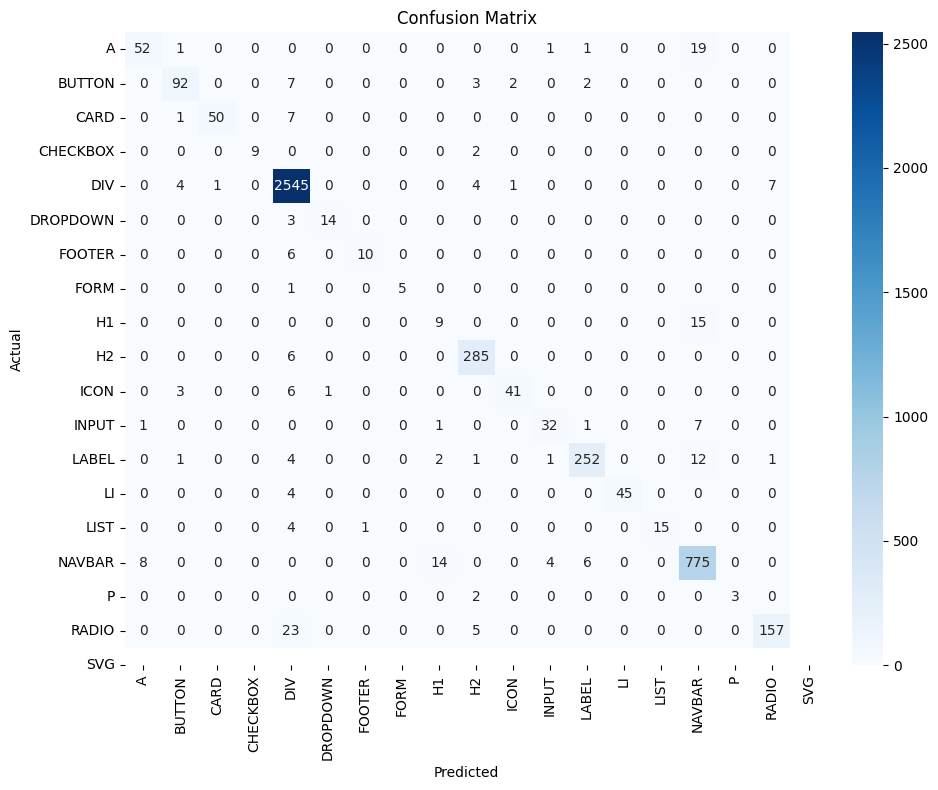

In [37]:
# Evaluate model on test set
y_pred = best_model.predict(preprocessor.transform(X_test))
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=tag_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tag_encoder.classes_, yticklabels=tag_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../models/rf/confusion_matrix.png')
plt.show()

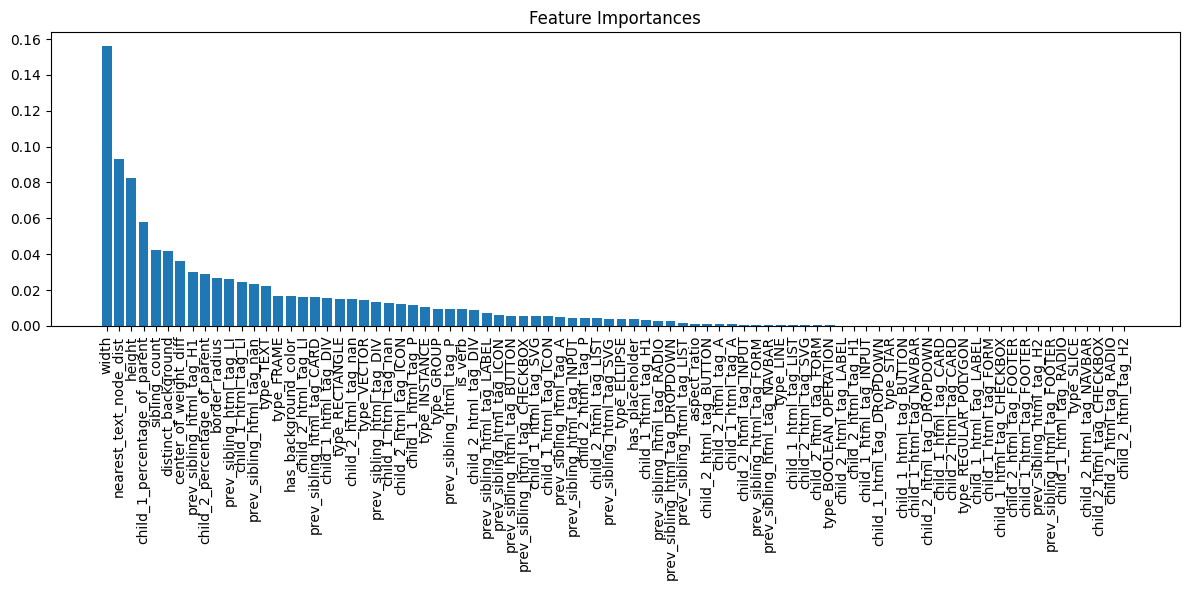

Feature importances saved to 'models/rf/feature_importances.csv'.
Evaluation metrics saved to '../models/rf/evaluation_metrics.json'.


In [39]:
# Plot feature importances
feature_names = (numerical_cols + 
                 preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols).tolist())
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('../models/rf/feature_importances.png')
plt.show()

# Save feature importances to CSV
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances.to_csv('../models/rf/feature_importances.csv', index=False)
print("Feature importances saved to 'models/rf/feature_importances.csv'.")

# Save evaluation metrics to JSON
metrics = {
    'accuracy': accuracy,
    # 'classification_report': classification_report(y_test, y_pred, target_names=tag_encoder.classes_, output_dict=True)
}
with open('../models/rf/evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print("Evaluation metrics saved to '../models/rf/evaluation_metrics.json'.")